# Imports

In [1]:
# imports
from typing import Tuple, List
from collections import deque

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Optimizer

import numpy as np
from torch import Tensor

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss

from lincoln.pytorch.layers import PyTorchLayer, DenseLayer
from lincoln.pytorch.model import PyTorchModel
from lincoln.pytorch.train import PyTorchTrainer
from lincoln.pytorch.preprocessor import ConvNetPreprocessor
from lincoln.pytorch.utils import assert_dim, permute_data

torch.manual_seed(20190325);

# setup gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# set default Tensor type (cpu or cuda)
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

torch.set_num_threads(8)

Using device: cuda:0


In [2]:
# autoreload reloads modules automatically before entering the 
# execution of code typed at the IPython prompt.
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Boston dataset

In [3]:
from sklearn.datasets import load_boston

boston = load_boston()
data = boston.data
target = boston.target
features = boston.feature_names

from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

X_train, X_test, y_train, y_test = Tensor(X_train).to(device), Tensor(X_test).to(device), Tensor(y_train).to(device), Tensor(y_test).to(device)

## Defining Boston model

In [4]:
class BostonModel(PyTorchModel):

    def __init__(self,
                 hidden_size: int = 13,
                 hidden_dropout: float = 1.0):
        super().__init__()
        self.dense1 = DenseLayer(13, hidden_size, 
                                 activation=nn.Tanh(),
                                 dropout = hidden_dropout)
        self.dense2 = DenseLayer(hidden_size, 1)

    def forward(self, x: Tensor,
                inference: bool = False) -> Tensor:
        
        assert_dim(x, 2)
        
        assert x.shape[1] == 13

        x = self.dense1(x, inference)
        return self.dense2(x, inference),

## Implementing Learning Rate Decay

In [5]:
# model, optimizer, loss
pytorch_boston_model = BostonModel(hidden_size=13, hidden_dropout=0.8)
pytorch_boston_model.to(device)
optimizer = optim.SGD(pytorch_boston_model.parameters(), lr=0.001, momentum=0.9)

In [6]:
criterion = nn.MSELoss()

In [7]:
trainer = PyTorchTrainer(pytorch_boston_model, optimizer, criterion, device)

trainer.fit(X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=100,
            eval_every=10,
            final_lr_exp = 0.001)

/mnt/md1/home/ascott/ascott_svn/SFSU/Fall_2019/CSC898/venv_python3.6_pythia/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


The loss after 1 epochs was 440.18560791015625
The loss after 11 epochs was 22.50460433959961
The loss after 21 epochs was 18.614288330078125
The loss after 31 epochs was 16.40505599975586
The loss after 41 epochs was 19.229036331176758
The loss after 51 epochs was 16.77082633972168
The loss after 61 epochs was 16.97479820251465
The loss after 71 epochs was 15.664215087890625
The loss after 81 epochs was 15.930442810058594
The loss after 91 epochs was 16.088298797607422


In [8]:
torch.mean(torch.pow(pytorch_boston_model(X_test, inference=True)[0] - y_test, 2)).item()

15.929999351501465

In [9]:
test_pred = pytorch_boston_model(X_test)[0].view(-1)
test_actual = y_test

In [10]:
test_pred = test_pred.cpu().detach().numpy()
test_actual = test_actual.cpu().detach().numpy()

## Boston - EDA

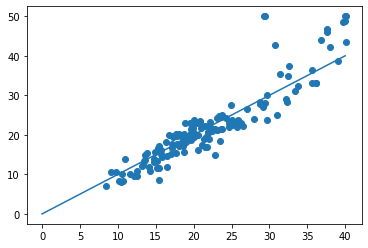

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(test_pred, test_actual)
plt.plot((0, 40), (0, 40))

# CNNs using PyTorch

We first show an example using `DataLoader`s, and then show one without using `DataLoader`s.

In [12]:
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1305,), (0.3081,))
])

In [13]:
# https://pytorch.org/docs/stable/data.html
train_dataset = MNIST(root='../mnist_data/',
                      train=True, 
                      download=True,
                      transform=img_transforms)

test_dataset = MNIST(root='../mnist_data/',
                     train=False, 
                     download=True,
                     transform=img_transforms)

# train_dataset = train_dataset.to(device)
# test_dataset = test_dataset.to(device)
# train_dataset.data = train_dataset.data.to(device)
# test_dataset.data = test_dataset.data.to(device)
train_dataset.targets = train_dataset.targets.to(device)
test_dataset.targets = test_dataset.targets.to(device)

In [14]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=60, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=60, 
                                           shuffle=False)

In [15]:
class ConvLayer(PyTorchLayer):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 filter_size: int,
                 activation: nn.Module = None,
                 dropout: float = 1.0,
                 flatten: bool = False) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, filter_size, 
                              padding=filter_size // 2)
        self.activation = activation
        self.flatten = flatten
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

    def forward(self, x: Tensor) -> Tensor:

        x = self.conv(x)
        if self.activation:
            x = self.activation(x)
        if self.flatten:
            x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        if hasattr(self, "dropout"):
            x = self.dropout(x)            
            
        return x

In [16]:
class MNIST_ConvNet(PyTorchModel):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvLayer(1, 14, 5, activation=nn.Tanh(),
                               dropout=0.8)
        self.conv2 = ConvLayer(14, 7, 5, activation=nn.Tanh(), flatten=True,
                               dropout=0.8)
        self.dense1 = DenseLayer(28 * 28 * 7, 32, activation=nn.Tanh(),
                                 dropout=0.8)
        self.dense2 = DenseLayer(32, 10)

    def forward(self, x: Tensor) -> Tensor:
        assert_dim(x, 4)
            
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.dense1(x)
        x = self.dense2(x)
        return x,

In [17]:
model = MNIST_ConvNet()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### Testing using only `Dataloader`

In [18]:
trainer = PyTorchTrainer(model, optimizer, criterion, device)

trainer.fit(train_dataloader = train_loader,        
            test_dataloader = test_loader,
            epochs = 1,
            eval_every = 1)

The loss after 0 epochs was 0.0873


## Accuracy using only the `DataLoader`

In [19]:
def test_accuracy(model):
    model.eval()
    accuracies = []
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        output = model(X_batch)[0]
        accuracy_batch = (torch.max(output, dim=1)[1] == y_batch).type(torch.float32).mean().item()
        accuracies.append(accuracy_batch)
    return torch.Tensor(accuracies).mean().item()

In [20]:
test_accuracy(model)

0.9742016792297363

## Without using `DataLoader`

### Preprocessing

In [21]:
mnist_train = ((train_dataset.data.type(torch.float32).unsqueeze(3).permute(0, 3, 1, 2) / 255.0) - 0.1305) / 0.3081
mnist_test = ((test_dataset.data.type(torch.float32).unsqueeze(3).permute(0, 3, 1, 2) / 255.0) - 0.1305) / 0.3081

In [22]:
mnist_train.min(), mnist_train.max(), mnist_test.min(), mnist_test.max()

# move to GPU
mnist_train = mnist_train.to(device)
mnist_test = mnist_test.to(device)

### Training

In [23]:
trainer = PyTorchTrainer(model, optimizer, criterion, device)

trainer.fit(X_train=mnist_train, y_train=train_dataset.targets, 
            X_test=mnist_test, y_test=test_dataset.targets,     
            epochs=1,
            eval_every=1)

The loss after 1 epochs was 0.08014460653066635


### Evaluating

In [24]:
def test_accuracy_no_dataloader(model, mnist_test):
    model.eval()
    output = model(mnist_test)[0]
    return (torch.max(output, dim=1)[1] == test_dataset.test_labels).type(torch.float32).mean().item()

In [25]:
test_accuracy_no_dataloader(model, mnist_test)

/mnt/md1/home/ascott/ascott_svn/SFSU/Fall_2019/CSC898/venv_python3.6_pythia/lib/python3.6/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


0.9747999906539917

~97.3% accuracy

# LSTM

## `LSTMLayer`

In [26]:
class LSTMLayer(PyTorchLayer):
    def __init__(self,
                 sequence_length: int,
                 input_size: int,
                 hidden_size: int,
                 output_size: int,
                 device: torch.device,
                 dropout: float = 1.0) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.h_init = torch.zeros((1, hidden_size))
        self.c_init = torch.zeros((1, hidden_size))
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = DenseLayer(hidden_size, output_size)
        self.device = device
        
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

        self.lstm = self.lstm.to(self.device)
        
    def _transform_hidden_batch(self, hidden: Tensor,
                                batch_size: int,
                                before_layer: bool) -> Tensor:
        
        if before_layer:
            return (hidden
                    .repeat(batch_size, 1)
                    .view(batch_size, 1, self.hidden_size)
                    .permute(1,0,2))
        else:
            return (hidden
                    .permute(1,0,2)
                    .mean(dim=0))         
    

    def forward(self, x: Tensor) -> Tensor:
        
        batch_size = x.shape[0]

        h_layer = self._transform_hidden_batch(self.h_init, batch_size, before_layer=True)
        c_layer = self._transform_hidden_batch(self.c_init, batch_size, before_layer=True)
        
        h_layer = h_layer.to(self.device)
        c_layer = c_layer.to(self.device)
        x = x.to(self.device)
        self.lstm = self.lstm.to(self.device)
        
        x, (h_out, c_out) = self.lstm(x, (h_layer, c_layer))
        
        self.h_init, self.c_init = (
            self._transform_hidden_batch(h_out, batch_size, before_layer=False).detach(),
            self._transform_hidden_batch(c_out, batch_size, before_layer=False).detach()
        )

        x = self.fc(x)
        if hasattr(self, "dropout"):
            x = self.dropout(x) 
            
        return x

In [27]:
lay = LSTMLayer(sequence_length=25,
          input_size=62,
          hidden_size=100,
          output_size=128, device=device)

x = torch.randn(32, 25, 62)
x = x.to(device)
lay = lay.to(device)

lay(x).shape

torch.Size([32, 25, 128])

## `NextCharacterModel`

In [28]:
class NextCharacterModel(PyTorchModel):
    def __init__(self,
                 vocab_size: int,
                 hidden_size: int = 256,
                 sequence_length: int = 25):
        super().__init__()
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        
        # In this model, we have only one layer, with the same output size as input_size
        self.lstm = LSTMLayer(self.sequence_length, self.vocab_size, hidden_size, self.vocab_size, device=device)

    def forward(self,
                inputs: Tensor):
        assert_dim(inputs, 3) # batch_size, sequence_length, vocab_size

        out = self.lstm(inputs)       
        
        return out.permute(0, 2, 1),

## `LSTMTrainer`

In [29]:
class LSTMTrainer(PyTorchTrainer):
    def __init__(self,
                 model: NextCharacterModel,
                 optim: Optimizer,
                 criterion: _Loss,
                 device: torch.device):
        super().__init__(model, optim, criterion, device)
        self.vocab_size = self.model.vocab_size
        self.max_len = self.model.sequence_length
        self.device = device
        
        
    def fit(self,
            data: str,
            epochs: int=10,
            eval_every: int=1,
            batch_size: int=32,
            seed: int = 121718)-> None:
        
        self.data = data
        self.train_data, self.test_data = self._train_test_split_text()
        self.chars = list(set(self.data))
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}

        torch.manual_seed(seed)

        losses = deque(maxlen=50)
        
        for e in range(epochs):

            batch_generator = self.generate_batches_next_char(batch_size)

            for ii, (X_batch, y_batch) in enumerate(batch_generator):

                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                self.model = self.model.to(self.device)
                
                self.optim.zero_grad()                
                outputs = self.model(X_batch)[0]

                loss = self.loss(outputs, y_batch)
                losses.append(loss.item())

                loss.backward()
                
                self.optim.step()    

            if (e+1) % eval_every == 0:

                X_test, y_test = self.generate_test_data()
                test_preds = self.model.forward(X_test)[0]
                X_test = X_test.to(self.device)
                y_test = y_test.to(self.device)

                loss = self.loss.forward(test_preds, y_test)
                print(f"Validation loss after {e+1} epochs is {loss.item():.3f}")

    def _train_test_split_text(self, pct=0.8) -> Tuple[str]:

        n = len(self.data)
        return self.data[:int(n * pct)], self.data[int(n * pct):]

    def generate_batches_next_char(self,
                                   batch_size: int) -> Tuple[Tensor]:
        N = len(self.train_data)
        # add batch size
        for ii in range(0, N, batch_size):

            features_tensors = []
            target_indices = []

            for char in range(batch_size):

                features_str, target_str =\
                 self.train_data[ii+char:ii+char+self.max_len],\
                 self.train_data[ii+char+1:ii+char+self.max_len+1]

                features_array = self._string_to_one_hot_array(features_str)
                target_indices_seq = [self.char_to_idx[char] for char in target_str]

                features_tensors.append(features_array)
                target_indices.append(target_indices_seq)
            if len(features_str) != len(target_str):
                break
            yield torch.stack(features_tensors).to(self.device), torch.LongTensor(target_indices).to(self.device)

    def _string_to_one_hot_array(self, input_string: str) -> Tuple[Tensor]:

        ind = [self.char_to_idx[ch] for ch in input_string]

        array = self._one_hot_text_data(ind)

        return array.to(self.device)

    def _one_hot_text_data(self,
                           sequence: List):

        sequence_length = len(sequence)
        batch = torch.zeros(sequence_length, self.vocab_size)
        for i in range(sequence_length):
            batch[i, sequence[i]] = 1.0

        return Tensor(batch).to(self.device)

    def generate_test_data(self) -> Tuple[Tensor]:

        features_str, target_str = self.test_data[:-1], self.test_data[1:]

        X_tensors = []
        y_tensors = []

        N = len(self.test_data)

        for start in range(0, N, self.max_len):

            features_str, target_str =\
                self.test_data[start:start+self.max_len],\
                self.test_data[start+1:start+self.max_len+1]

            if len(features_str) != len(target_str):
                break
            features_array = self._string_to_one_hot_array(features_str)
            target_indices_seq = [self.char_to_idx[char] for char in target_str]

            X_tensors.append(features_array)
            y_tensors.append(torch.LongTensor(target_indices_seq))
            
        return torch.stack(X_tensors).to(self.device), torch.stack(y_tensors).to(self.device)


In [30]:
torch.set_num_threads(16)
data = open('../06_rnns/input.txt', 'r').read()
vocab_size = len(set(data))
model = NextCharacterModel(vocab_size, hidden_size=vocab_size, sequence_length=50)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                             weight_decay=1e-5)

In [31]:
lstm_trainer = LSTMTrainer(model, optimizer, criterion, device)

In [32]:
lstm_trainer.fit(data, epochs=1)

Validation loss after 1 epochs is 2.313


# Unsupervised Learning with Autoencoder

## `DeconvLayer`

In [33]:
class DeconvLayer(PyTorchLayer):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 filter_size: int,
                 activation: nn.Module = None,
                 dropout: float = 1.0,
                 flatten: bool = False) -> None:
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, filter_size, 
                                       padding=filter_size // 2)
        self.activation = activation
        self.flatten = flatten
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

    def forward(self, x: Tensor) -> Tensor:

        x = self.deconv(x)
        if self.activation:
            x = self.activation(x)
        if self.flatten:
            x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        if hasattr(self, "dropout"):
            x = self.dropout(x)            
            
        return x

## `Autoencoder`

In [34]:
class Autoencoder(PyTorchModel):
    def __init__(self,
                 hidden_dim: int = 28):
        super(Autoencoder, self).__init__()
        self.conv1 = ConvLayer(1, 14, 5, activation=nn.Tanh())
        self.conv2 = ConvLayer(14, 7, 5, activation=nn.Tanh(), flatten=True)
        
        self.dense1 = DenseLayer(7 * 28 * 28, hidden_dim, activation=nn.Tanh())
        self.dense2 = DenseLayer(hidden_dim, 7 * 28 * 28, activation=nn.Tanh())
        
        self.conv3 = ConvLayer(7, 14, 5, activation=nn.Tanh()) 
        self.conv4 = ConvLayer(14, 1, 5, activation=nn.Tanh())         

    def forward(self, x: Tensor) -> Tensor:
        assert_dim(x, 4)
            
        x = self.conv1(x)
        x = self.conv2(x)
#         import pdb; pdb.set_trace()
        encoding = self.dense1(x)
        
        x = self.dense2(encoding)
        
        x = x.view(-1, 7, 28, 28)
        
        x = self.conv3(x)
        x = self.conv4(x)

        return x, encoding

## Preprocess data

In [35]:
X_train = mnist_train
X_test = mnist_test

In [36]:
X_train_auto = (X_train - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1
X_test_auto = (X_test - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1

In [41]:
model = Autoencoder()

In [44]:
model = Autoencoder(hidden_dim=28)
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

trainer = PyTorchTrainer(model, optimizer, criterion, device=device)

trainer.fit(X_train_auto, X_train_auto,
            X_test_auto, X_test_auto,
            epochs=1,
            batch_size=60)

The loss after 1 epochs was 0.06818987429141998


In [45]:
reconstructed_images, image_representations = model(X_test_auto)

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [47]:
def display_image(ax,
    t: Tensor):
    n = t.detach().numpy()
    ax.imshow(n.reshape(28, 28))

In [48]:
np.random.seed(20190504)
a = np.random.randint(0, 10000)

In [49]:
X_test[a].shape

torch.Size([1, 28, 28])

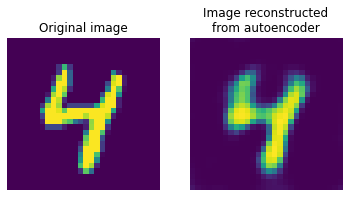

In [50]:
f, axarr = plt.subplots(1,2)
display_image(axarr[0], X_test[a].cpu())
display_image(axarr[1], reconstructed_images[a].cpu())

axarr[0].set_title("Original image")
axarr[1].set_title("Image reconstructed\nfrom autoencoder")

axarr[0].axis('off')
axarr[1].axis('off');

# f.savefig("../../01_deep-learning-from-scratch/images/07_pytorch/03_autoencoder_example_image.png")

# TSNE on the results

In [51]:
from sklearn.manifold import TSNE
tsne_result = TSNE(n_components=2, random_state=20190405).fit_transform(image_representations.cpu().detach().numpy())

## TSNE viz

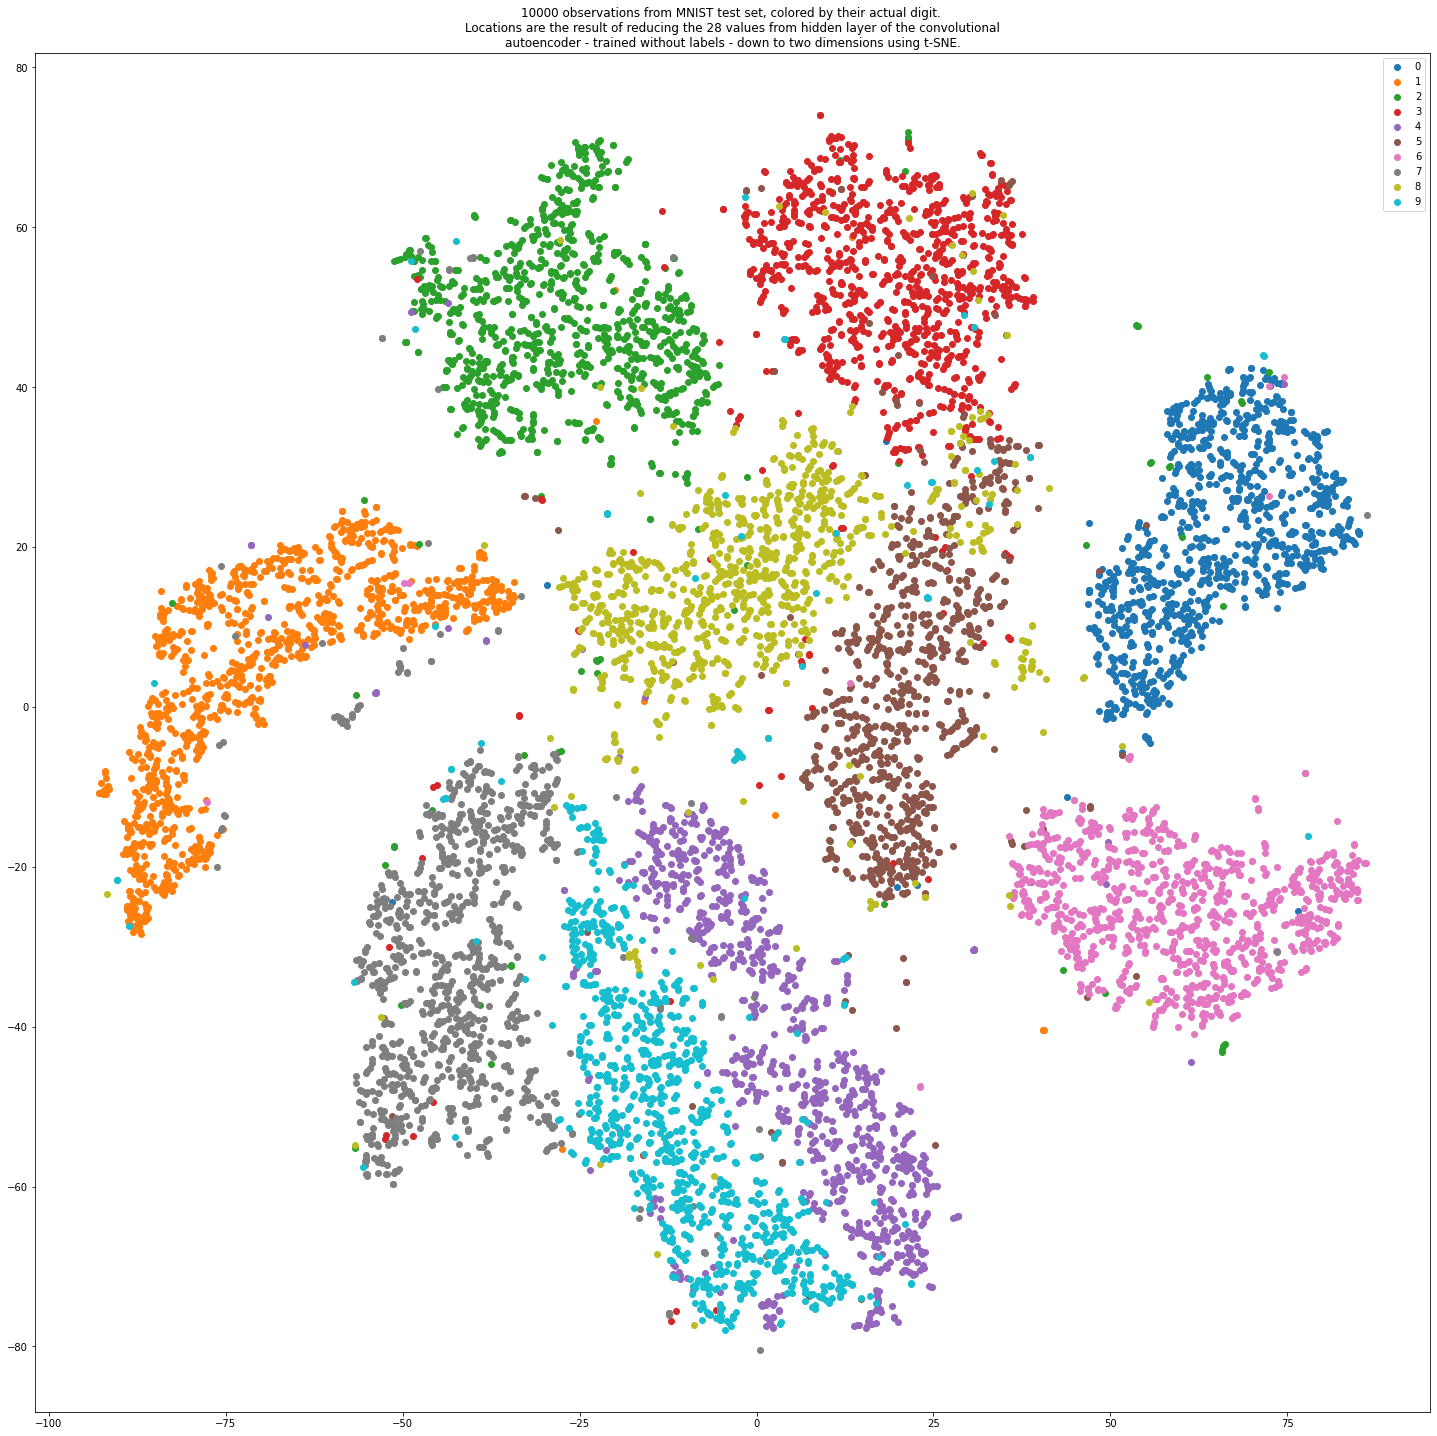

In [52]:
test_dataset.targets = test_dataset.targets.to('cpu')
import pandas as pd
tsne_df = pd.DataFrame({'tsne_dim_1': tsne_result[:,0],
              'tsne_dim_2': tsne_result[:,1],
              'category': test_dataset.targets})
groups = tsne_df.groupby('category')

# Plot
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title('''10000 observations from MNIST test set, colored by their actual digit. 
Locations are the result of reducing the 28 values from hidden layer of the convolutional
autoencoder - trained without labels - down to two dimensions using t-SNE.''')
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.scatter(group['tsne_dim_1'], group['tsne_dim_2'], marker='o', label=name)
ax.legend();
# fig.savefig("../../01_deep-learning-from-scratch/images/07_pytorch/00_tsne.png")